# Antibody Response Pulse
https://github.com/blab/antibody-response-pulse

### B-cells evolution --- cross-reactive antibody response after influenza virus infection or vaccination
### Adaptive immune response for sequential infection

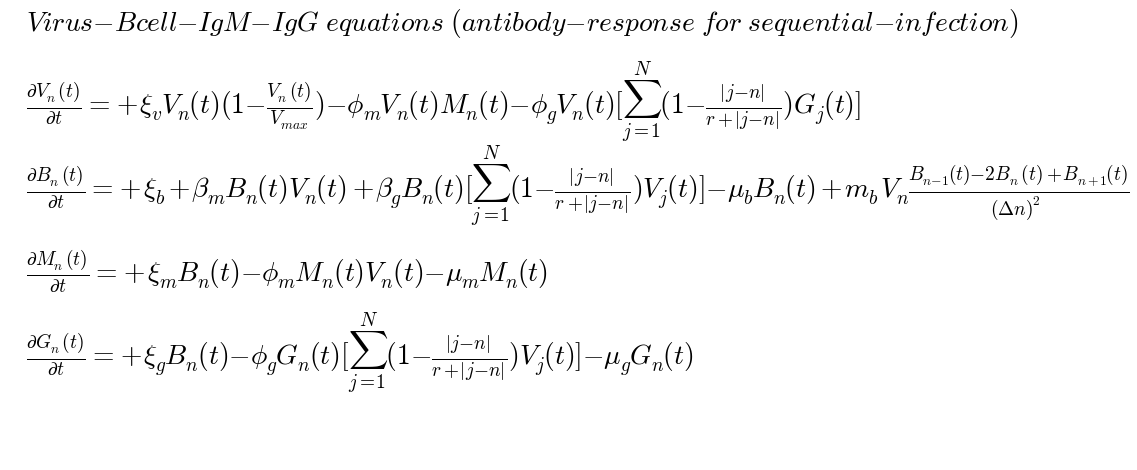

In [13]:
'''
author: Alvason Zhenhua Li
date:   04/09/2015
'''
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib.ticker import FuncFormatter

import alva_machinery_VBMG as alva

AlvaFontSize = 23
AlvaFigSize = (15, 5)
numberingFig = 0

# equation
dir_path = '/Users/al/Desktop/GitHub/antibody-response-pulse/figure'
file_name = 'VBMG-infection'
figure_name = '-equation'
file_suffix = '.png'
save_figure = os.path.join(dir_path, file_name + figure_name + file_suffix)

text_list = [r'$ Virus-Bcell-IgM-IgG \ equations \ (antibody-response \ for \ sequential-infection)$'
             , r'$ \frac{\partial V_n(t)}{\partial t} = \
             + \xi_{v}V_{n}(t)(1 - \frac{V_n(t)}{V_{max}}) \
             - \phi_{m} V_{n}(t) M_{n}(t) \
             - \phi_{g} V_{n}(t) [\sum_{j = 1}^{N} (1 - \frac{|j - n|}{r + |j - n|})G_{j}(t)] $'
             , r'$ \frac{\partial B_n(t)}{\partial t} = \
             + \xi_{b} \
             + \beta_{m} B_{n}(t) V_{n}(t)  \
             + \beta_{g} B_{n}(t)[\sum_{j = 1}^{N} (1 - \frac{|j - n|}{r + |j - n|})V_{j}(t)] \
             - \mu_{b} B_{n}(t) \
             + m_b V_{n}\frac{B_{n-1}(t) - 2B_n(t) + B_{n+1}(t)}{(\Delta n)^2} $'
             , r'$ \frac{\partial M_n(t)}{\partial t} = \
             + \xi_{m} B_{n}(t) \
             - \phi_{m} M_{n}(t) V_{n}(t) \
             - \mu_{m} M_{n}(t) $'
             , r'$ \frac{\partial G_n(t)}{\partial t} = \
             + \xi_{g} B_{n}(t) \
             - \phi_{g} G_{n}(t) [\sum_{j = 1}^{N} (1 - \frac{|j - n|}{r + |j - n|})V_{j}(t)]  \
             - \mu_{g} G_{n}(t) $'
            ]
total_list = np.size(text_list)
numberingFig = numberingFig + 1
plt.figure(numberingFig, figsize=(total_list, total_list*1.5))
plt.axis('off')
for i in range(total_list):
    plt.text(0, (total_list - float(i))/total_list
             , text_list[i].replace('\\\n', '')
             , fontsize = 1.2*AlvaFontSize)
plt.savefig(save_figure, dpi = 100, bbox_inches='tight')
plt.show()

In [14]:
'''define the V-B-M-G partial differential equations'''

# inverted-monod equation
def monodInvert(half_radius, i):
    if half_radius == 0:
        gOut = i*0
        # numpy.reshape will not change the structure of i, 
        # so that the first element of i(unkonwn-size-array) can be setted by array_to_list[0] 
        array_to_list = np.reshape(i,[i.size,1]) 
        array_to_list[0] = 1 
    else: gOut = 1 - np.absolute(i)/(half_radius + np.absolute(i))
    return (gOut)

# cross immunity
def crossI_neighborSum_X(gI, half_radius, gX):
    total_neighbor_X = gX.shape[0]
    I_neighborSum = np.zeros(total_neighbor_X)
    # all I[xn] with neighbor-sum 
    ratioM = np.zeros([total_neighbor_X, total_neighbor_X])
    gXX = np.tile(gX, [total_neighbor_X, 1])
    gII = np.tile(gI, [total_neighbor_X, 1])
    ratioM[:, :] = monodInvert(half_radius, gXX[:, :] - gXX[:, :].T)
    I_neighborSum[:] = np.sum(ratioM[:, :] * gII[:, :].T, axis = 0)
    if half_radius == 0:
        I_neighborSum = np.copy(gI)
    return (I_neighborSum)

def dVdt_array(VBMGxt = [], *args):
    # naming
    V = VBMGxt[0]
    B = VBMGxt[1]
    M = VBMGxt[2]
    G = VBMGxt[3]
    x_totalPoint = VBMGxt.shape[1]
    # there are n dSdt
    dV_dt_array = np.zeros(x_totalPoint)
    # each dSdt with the same equation form
    dV_dt_array[:] = +inRateV*V[:]*(1 - V[:]/maxV) \
                     - killRateVm*M[:]*V[:] \
                     - killRateVg*V[:]*crossI_neighborSum_X(G, cross_radius, gX)[:]
    return(dV_dt_array)

def dBdt_array(VBMGxt = [], *args):
    # naming
    V = VBMGxt[0]
    B = VBMGxt[1]
    M = VBMGxt[2]
    G = VBMGxt[3]
    x_totalPoint = VBMGxt.shape[1]
    # there are n dSdt
    dB_dt_array = np.zeros(x_totalPoint)
    # each dSdt with the same equation form
    Bcopy = np.copy(B)
    centerX = Bcopy[:]
    leftX = np.roll(Bcopy[:], 1)
    rightX = np.roll(Bcopy[:], -1)
    leftX[0] = centerX[0]
    rightX[-1] = centerX[-1]
    dB_dt_array[:] = +inRateB \
                     + actRateBm*V[:]*B[:] \
                     + (actRateBg \
                        + alva.event_recovered \
                        + alva.event_OAS_boost)*B[:]*crossI_neighborSum_X(V, cross_radius, gX)[:] \
                     - (outRateB)*B[:] \
                     + mutatRateB*V[:]*(leftX[:] - 2*centerX[:] + rightX[:])/(dx**2)
    return(dB_dt_array)

def dMdt_array(VBMGxt = [], *args):
    # naming
    V = VBMGxt[0]
    B = VBMGxt[1]
    M = VBMGxt[2]
    G = VBMGxt[3]
    x_totalPoint = VBMGxt.shape[1]
    # there are n dSdt
    dM_dt_array = np.zeros(x_totalPoint)
    # each dSdt with the same equation form
    dM_dt_array[:] = +inRateM*B[:] - consumeRateM*M[:]*V[:] - outRateM*M[:]
    return(dM_dt_array)

def dGdt_array(VBMGxt = [], *args):
    # naming
    V = VBMGxt[0]
    B = VBMGxt[1]
    M = VBMGxt[2]
    G = VBMGxt[3]
    x_totalPoint = VBMGxt.shape[1]
    # there are n dSdt
    dG_dt_array = np.zeros(x_totalPoint)
    # each dSdt with the same equation form
    Gcopy = np.copy(G)
    centerX = Gcopy[:]
    leftX = np.roll(Gcopy[:], 1)
    rightX = np.roll(Gcopy[:], -1)
    leftX[0] = centerX[0]
    rightX[-1] = centerX[-1]
    dG_dt_array[:] = (+inRateG + alva.event_OAS_press)*B[:] \
                     - consumeRateG*G[:]*crossI_neighborSum_X(V, cross_radius, gX)[:] \
                     - outRateG*G[:]
    return(dG_dt_array)

event_infect = [[  0.           0.        ]
 [  0.           1.89863014]
 [  4.           3.87123288]
 [  4.           5.84383562]
 [  4.           7.81643836]
 [  4.           9.7890411 ]
 [  4.          11.76164384]
 [  4.          13.73424658]
 [  4.          15.70684932]
 [  4.          17.67945205]
 [  0.          19.65205479]
 [  0.          21.62465753]
 [  0.          23.59726027]]
event_repeated = [[ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]]


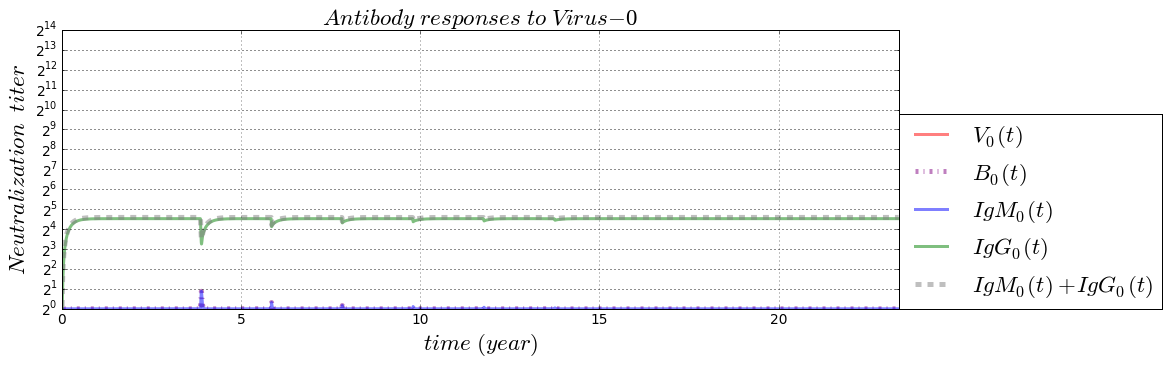

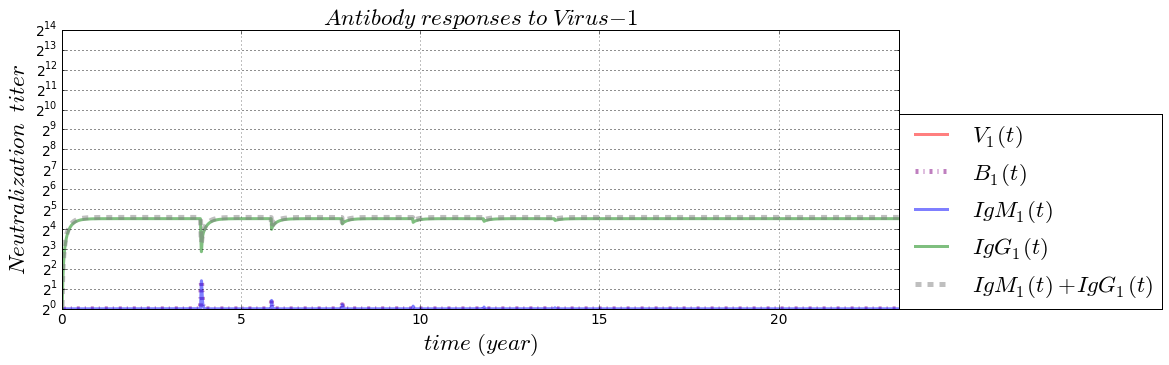

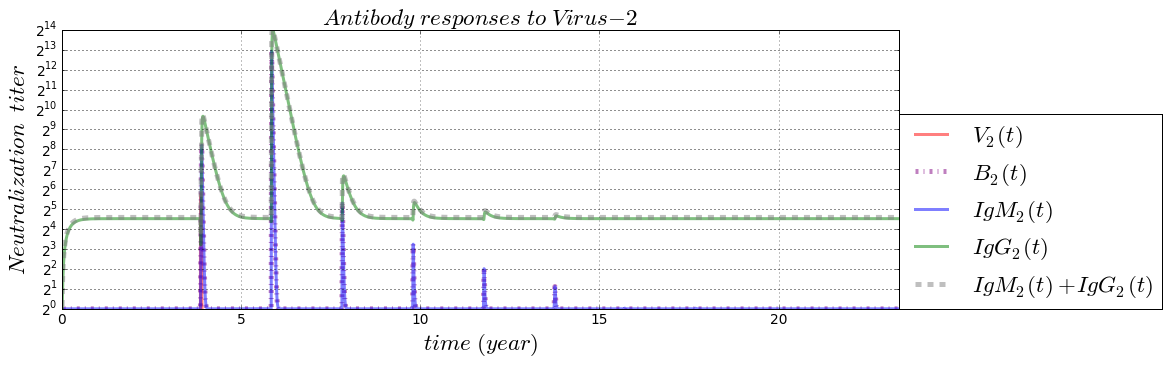

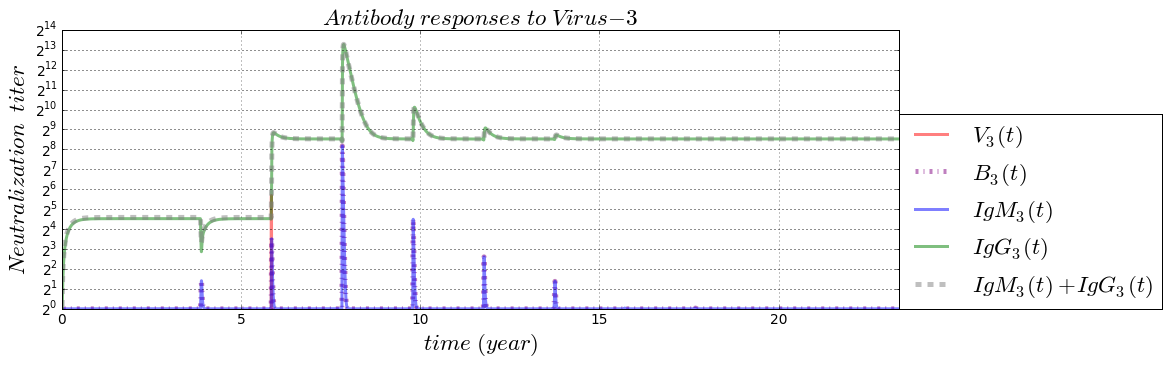

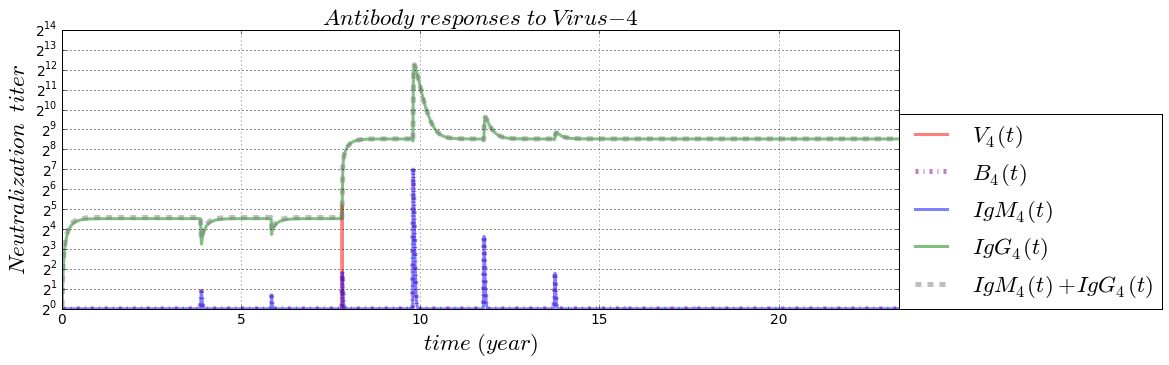

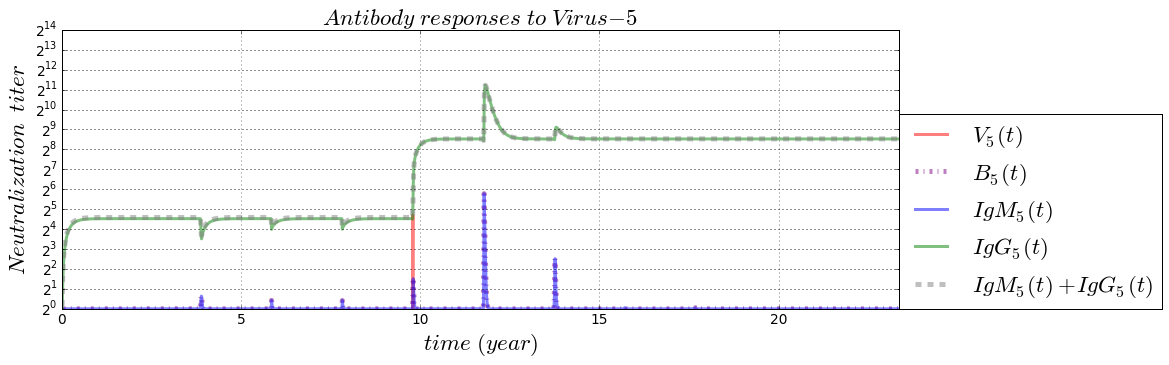

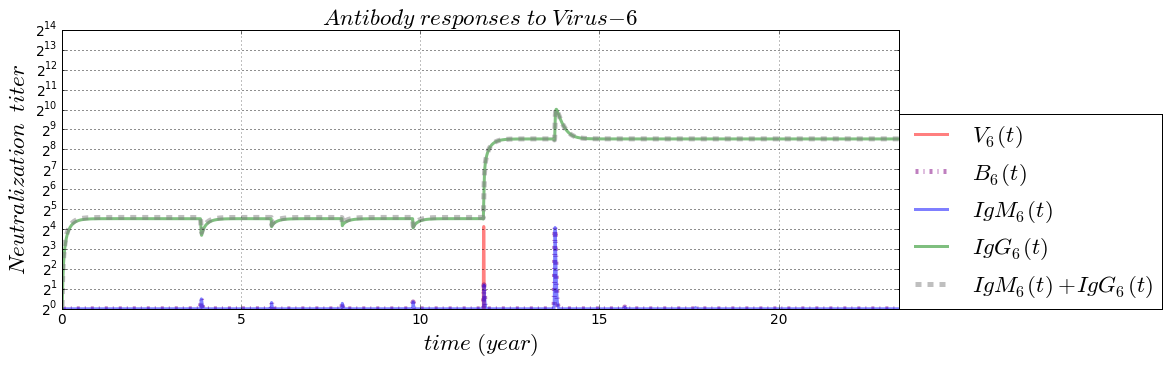

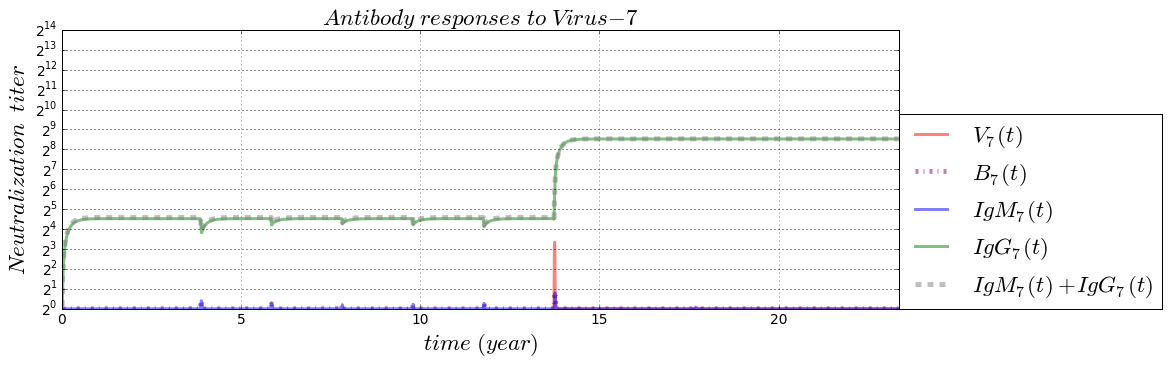

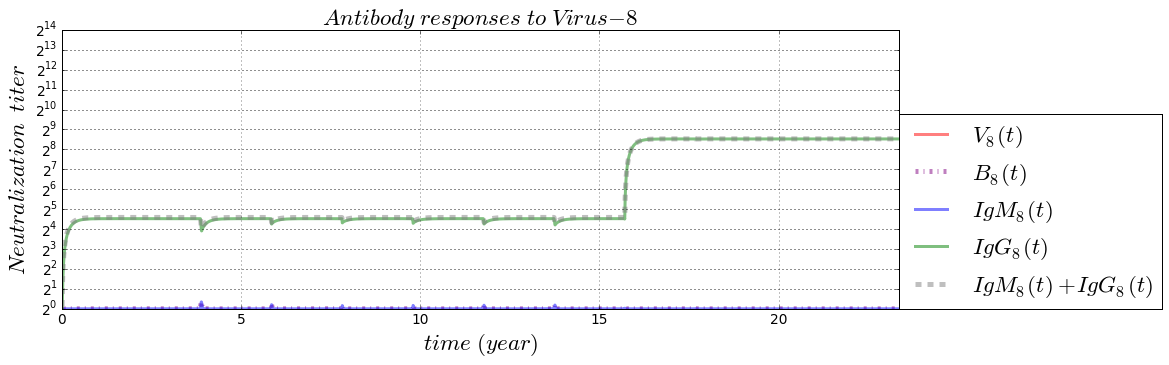

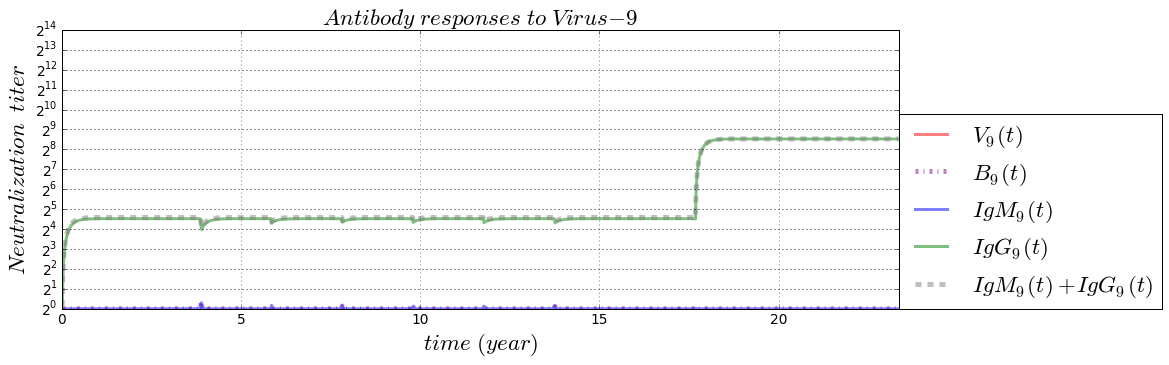

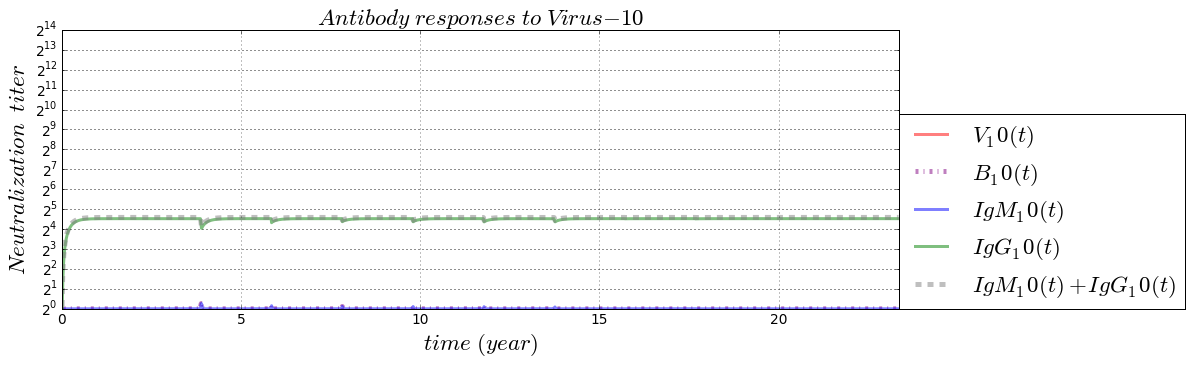

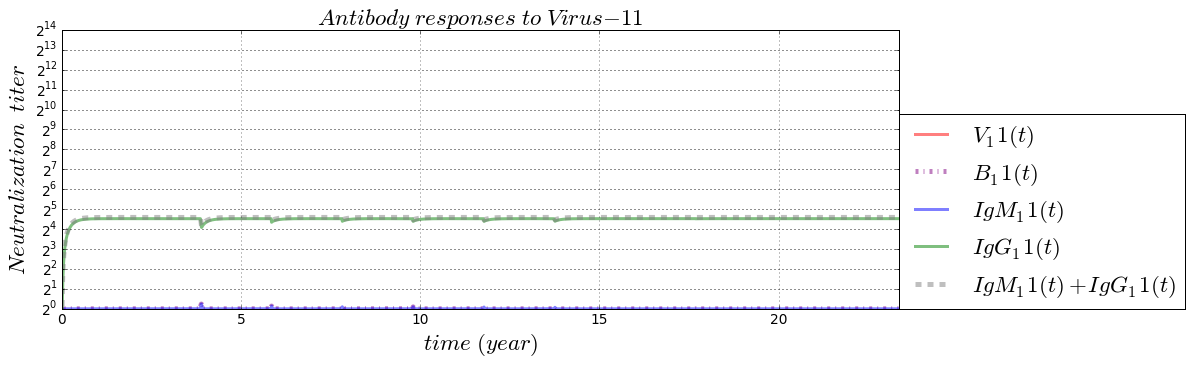

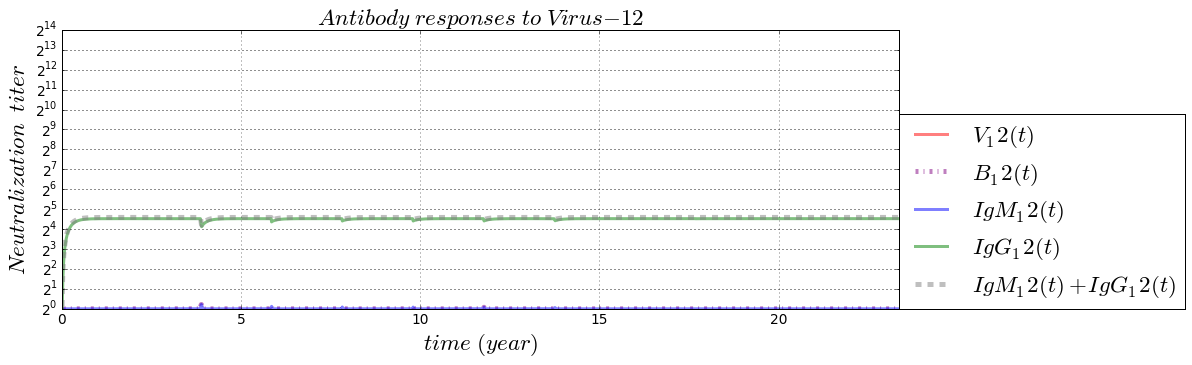

In [15]:
# setting parameter
timeUnit = 'year'
if timeUnit == 'hour':
    hour = float(1)
    day = float(24)
elif timeUnit == 'day':
    day = float(1)
    hour = float(1)/24 
elif timeUnit == 'year':
    year = float(1)
    day = float(1)/365
    hour = float(1)/24/365 
    
maxV = float(60) # max virus/micro-liter
inRateV = 0.2/hour # in-rate of virus
killRateVm = 0.0003/hour # kill-rate of virus by antibody-IgM
killRateVg = killRateVm # kill-rate of virus by antibody-IgG

inRateB = 0.0075/hour # in-rate of B-cell
outRateB = inRateB/1 # out-rate of B-cell
actRateBm = killRateVm # activation rate of naive B-cell
actRateBg = killRateVg # activation rate of naive B-cell

inRateM = 0.16/hour # in-rate of antibody-IgM from naive B-cell
outRateM = inRateM/1  # out-rate of antibody-IgM from naive B-cell
consumeRateM = killRateVm # consume-rate of antibody-IgM by cleaning virus

inRateG = inRateM/10 # in-rate of antibody-IgG from memory B-cell
outRateG = outRateM/230 # out-rate of antibody-IgG from memory B-cell
consumeRateG = killRateVg  # consume-rate of antibody-IgG by cleaning virus
    
mutatRateB = 10**(-6)/hour # Virus mutation rate

cross_radius = float(1) # radius of cross-immunity (the distance of half-of-value in the Monod equation)

# space boundary and griding condition
minX = float(0)
maxX = float(12)
totalPoint_X = int(maxX - minX + 1)
gX = np.linspace(minX, maxX, totalPoint_X)
gridingX = np.linspace(minX, maxX, num = totalPoint_X, retstep = True)
gX = gridingX[0]
dx = gridingX[1]
# time boundary and griding condition
infection_period = 2*12*30*day
minT = float(0)
maxT = float(infection_period*maxX*12*30*day)
totalPoint_T = int(2*10**4 + 1)
gT = np.linspace(minT, maxT, totalPoint_T)
spacingT = np.linspace(minT, maxT, num = totalPoint_T, retstep = True)
gT = spacingT[0]
dt = spacingT[1]

gV_array = np.zeros([totalPoint_X, totalPoint_T])
gB_array = np.zeros([totalPoint_X, totalPoint_T])
gM_array = np.zeros([totalPoint_X, totalPoint_T])
gG_array = np.zeros([totalPoint_X, totalPoint_T])
# initial output condition
#gV_array[1, 0] = float(2)

# [viral population, starting time] ---first
origin_virus = int(2)
current_virus = int(maxX - 3)
viral_population = np.zeros(int(maxX + 1))
viral_population[origin_virus:current_virus + 1] = 4
infection_starting_time = np.arange(int(maxX + 1))*infection_period - 27*day
event_infect = np.zeros([int(maxX + 1), 2])
event_infect[:, 0] = viral_population
event_infect[:, 1] = infection_starting_time
event_infect[0, 1] = 0
print ('event_infect = {:}'.format(event_infect)) 

# [viral population, starting time] ---repeated
viral_population = np.zeros(int(maxX + 1))
viral_population[origin_virus:current_virus + 1] = 0
infection_starting_time = np.arange(int(maxX + 1))*0
event_repeated = np.zeros([int(maxX + 1), 2])
event_repeated[:, 0] = viral_population
event_repeated[:, 1] = infection_starting_time
print ('event_repeated = {:}'.format(event_repeated)) 

#[origin-virus, current-virus, recovered-day, repeated-parameter, OAS+, OSA-]
min_cell = 1 # minimum cell
recovered_time = 14*day # recovered time of 1st-time infection 
actRateBg_recovered = actRateBg*10 # boosting up activation rate of memory B-cell for repeated-infection (same virus)
actRateBg_OAS_boost = actRateBg*15 # boosting up activation rate of memory B-cell for origin-virus
inRateG_OAS_press = inRateG*15 # depress in-rate of antibody-IgG from memory B-cell for current-virus
event_infection_parameter = np.array([origin_virus,
                                      current_virus, 
                                      min_cell, 
                                      recovered_time,
                                      actRateBg_recovered,
                                      actRateBg_OAS_boost,
                                      inRateG_OAS_press])

event_parameter = np.array([event_infection_parameter])

event_table = np.array([event_parameter, event_infect, event_repeated])
# Runge Kutta numerical solution
pde_array = np.array([dVdt_array, dBdt_array, dMdt_array, dGdt_array])
initial_Out = np.array([gV_array, gB_array, gM_array, gG_array])
gOut_array = alva.AlvaRungeKutta4XT(pde_array, initial_Out, minX, maxX, totalPoint_X
                                    , minT, maxT, totalPoint_T, event_table)

# plotting
gV = gOut_array[0]  
gB = gOut_array[1] 
gM = gOut_array[2]
gG = gOut_array[3]

numberingFig = numberingFig + 1
for i in range(totalPoint_X):
    figure_name = '-response-{:}'.format(i)
    figure_suffix = '.png'
    save_figure = os.path.join(dir_path, file_name + figure_name + file_suffix)
    plt.figure(numberingFig, figsize = AlvaFigSize)
    plt.plot(gT, gV[i], color = 'red', label = r'$ V_{:}(t) $'.format(i), linewidth = 3.0, alpha = 0.5)
    plt.plot(gT, gB[i], color = 'purple', label = r'$ B_{:}(t) $'.format(i), linewidth = 5.0, alpha = 0.5
             , linestyle = '-.')
    plt.plot(gT, gM[i], color = 'blue', label = r'$ IgM_{:}(t) $'.format(i), linewidth = 3.0, alpha = 0.5)
    plt.plot(gT, gG[i], color = 'green', label = r'$ IgG_{:}(t) $'.format(i), linewidth = 3.0, alpha = 0.5)
    plt.plot(gT, gM[i] + gG[i], color = 'gray', linewidth = 5.0, alpha = 0.5, linestyle = 'dashed'
             , label = r'$ IgM_{:}(t) + IgG_{:}(t) $'.format(i, i))
    plt.grid(True, which = 'both')
    plt.title(r'$ Antibody \ responses \ to \ Virus-{:} $'.format(i), fontsize = AlvaFontSize)
    plt.xlabel(r'$time \ ({:})$'.format(timeUnit), fontsize = AlvaFontSize)
    plt.ylabel(r'$ Neutralization \ \ titer $', fontsize = AlvaFontSize)
    plt.xlim([minT, maxT])
    plt.xticks(fontsize = AlvaFontSize*0.6)
    plt.yticks(fontsize = AlvaFontSize*0.6) 
    plt.ylim([2**0, 2**14])
    plt.yscale('log', basey = 2)
    plt.legend(loc = (1,0), fontsize = AlvaFontSize)
    plt.savefig(save_figure, dpi = 100, bbox_inches='tight')
    plt.show()

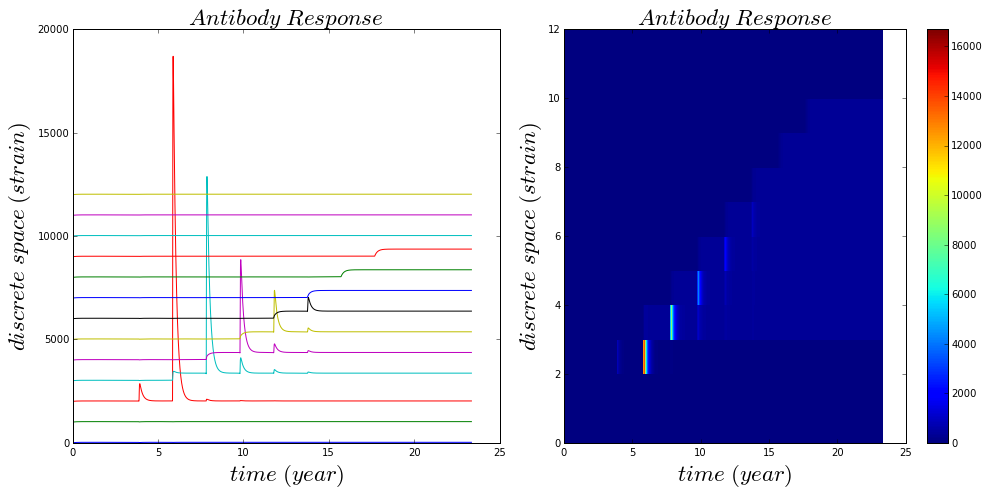

In [16]:
numberingFig = numberingFig + 1;
figure = plt.figure(numberingFig, figsize = (14, 7))
plot1 = figure.add_subplot(1, 2, 2)
#colorPlot = plot1.contourf(gT, gX, gI, levels = np.arange(0, 0.12, 0.001))
colorPlot = plot1.pcolor(gT, gX, (gM + gG))
plt.title(r'$ Antibody \ Response $', fontsize = AlvaFontSize)
plt.xlabel(r'$time \ ({:})$'.format(timeUnit), fontsize = AlvaFontSize);
plt.ylabel(r'$ discrete \ space \ (strain) $', fontsize = AlvaFontSize)
plt.colorbar(colorPlot)

plot2 = figure.add_subplot(1, 2, 1)
plot2.plot(gT, ((gM + gG).T + np.arange(totalPoint_X)*1000))
plt.title(r'$ Antibody \ Response $', fontsize = AlvaFontSize)
plt.xlabel(r'$time \ ({:})$'.format(timeUnit), fontsize = AlvaFontSize)
plt.ylabel(r'$ discrete \ space \ (strain) $', fontsize = AlvaFontSize)

figure.tight_layout()
plt.show()

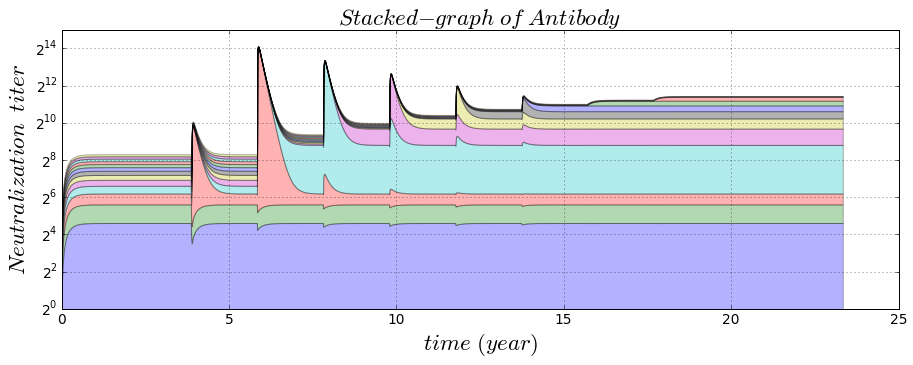

In [17]:
# Normalization stacked graph
numberingFig = numberingFig + 1
plt.figure(numberingFig, figsize = AlvaFigSize)
plt.stackplot(gT, gM + gG, alpha = 0.3)
plt.title(r'$ Stacked-graph \ of \ Antibody $', fontsize = AlvaFontSize)
plt.xlabel(r'$time \ ({:})$'.format(timeUnit), fontsize = AlvaFontSize)
plt.ylabel(r'$ Neutralization \ \ titer $', fontsize = AlvaFontSize)
plt.xticks(fontsize = AlvaFontSize*0.6)
plt.yticks(fontsize = AlvaFontSize*0.6) 
plt.ylim([2**0, 2**15])
plt.yscale('log', basey = 2)
plt.grid(True)
plt.show()

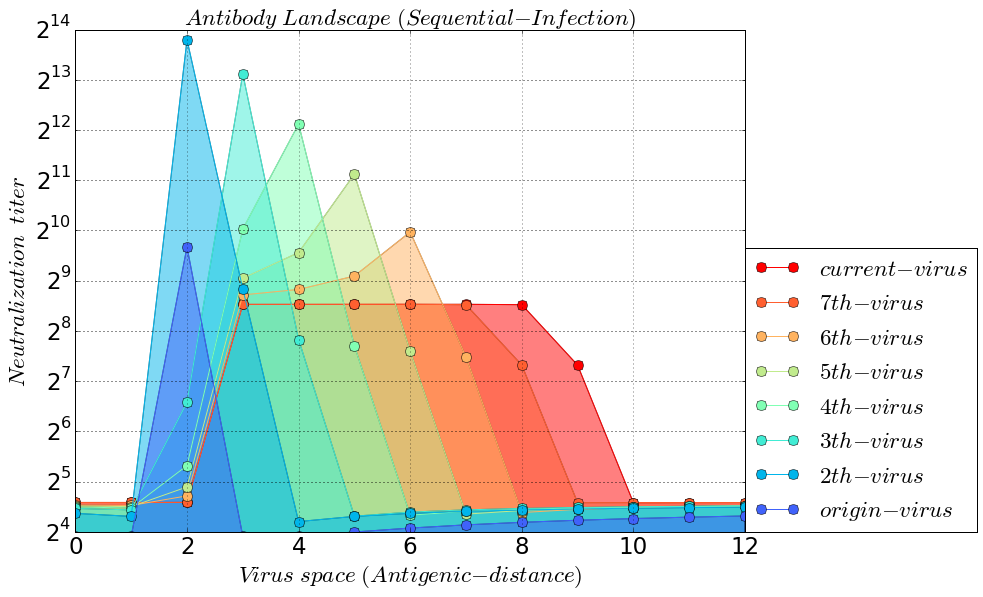

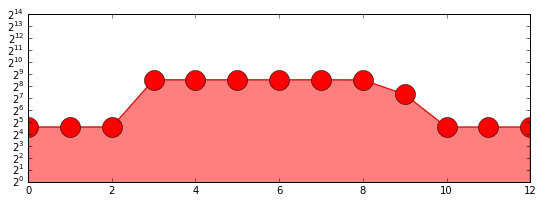

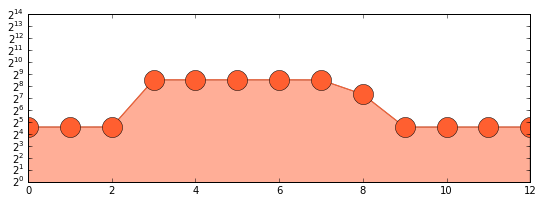

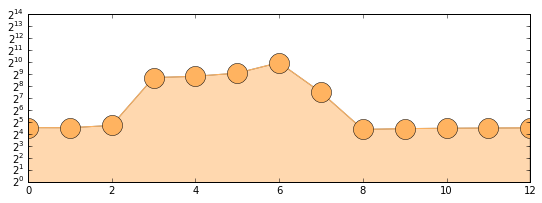

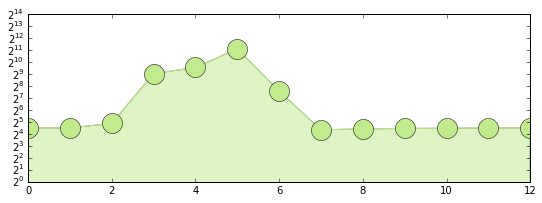

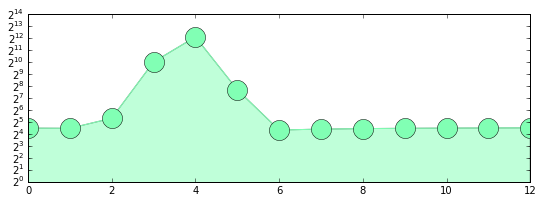

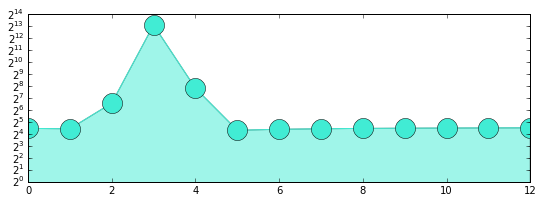

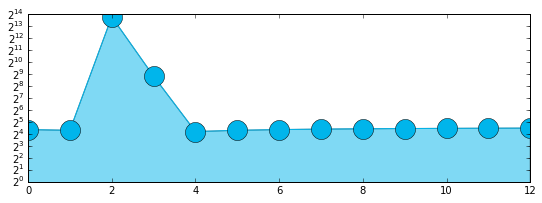

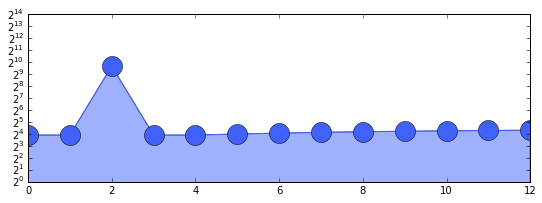

In [18]:
# expected peak of the antibody response
totalColor = current_virus - origin_virus + 1 
AlvaColor = [plt.get_cmap('rainbow')(float(i)/(totalColor)) for i in range(1, totalColor + 1)]

sample_time = 3*day
# plotting
figure_name = '-landscape'
figure_suffix = '.png'
save_figure = os.path.join(dir_path, file_name + figure_name + file_suffix)

numberingFig = numberingFig + 1
plt.figure(numberingFig, figsize = (12, 9))
for i in range(origin_virus, current_virus + 1):
    detect_xn = current_virus + 2 - i
    if detect_xn == origin_virus:
        virus_label = '$ origin-virus $'
    elif detect_xn == current_virus:
        virus_label = '$ current-virus $' 
    else: virus_label = '$ {:}th-virus $'.format(detect_xn - origin_virus + 1)
    detect_time = int(totalPoint_T/(maxT - minT)*(detect_xn*infection_period + sample_time))
    plt.plot(gX, gM[:, detect_time] + gG[:, detect_time], marker = 'o', markersize = 10
             , color = AlvaColor[detect_xn - origin_virus], label = virus_label)
    plt.fill_between(gX, gM[:, detect_time] + gG[:, detect_time], facecolor = AlvaColor[detect_xn - origin_virus]
                     , alpha = 0.5)
    
plt.grid(True, which = 'both')
plt.title(r'$ Antibody \ Landscape \ (Sequential-Infection)$', fontsize = AlvaFontSize)
plt.xlabel(r'$ Virus \ space \ (Antigenic-distance) $', fontsize = AlvaFontSize)
plt.ylabel(r'$ Neutralization \ \ titer $', fontsize = AlvaFontSize)
plt.xlim([minX, maxX])
plt.xticks(fontsize = AlvaFontSize)
plt.yticks(fontsize = AlvaFontSize) 
plt.ylim([2**4, 2**14])
plt.yscale('log', basey = 2)
plt.legend(loc = (1,0), fontsize = AlvaFontSize)
plt.savefig(save_figure, dpi = 100, bbox_inches='tight')
plt.show()

# each frame
numberingFig = numberingFig + 1
for i in range(origin_virus, current_virus + 1):
    plt.figure(numberingFig, figsize = (9, 3))
    detect_xn = current_virus + 2 - i
    if detect_xn == origin_virus:
        virus_label = '$ origin-virus $'
    elif detect_xn == current_virus:
        virus_label = '$ current-virus $' 
    else: virus_label = '$ {:}th-virus $'.format(detect_xn - origin_virus + 1)
    detect_time = int(totalPoint_T/(maxT - minT)*(detect_xn*infection_period + sample_time))
    plt.plot(gX, gM[:, detect_time] + gG[:, detect_time], marker = 'o', markersize = 20
             , color = AlvaColor[detect_xn - origin_virus], label = virus_label)
    plt.fill_between(gX, gM[:, detect_time] + gG[:, detect_time], facecolor = AlvaColor[detect_xn - origin_virus]
                     , alpha = 0.5)
    plt.ylim([2**0, 2**14])
    plt.yscale('log', basey = 2)
    plt.show()